In [1]:
# Computational Physics Project 4 - Molecular Orbital Theory
# Ben Zager, Zach Faber-Manning, Michael Rosen

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh,solve
from scipy.io import loadmat


In [11]:
# Constants

# adjacency matrix of carbons
buta = np.loadtxt("butadiene.txt")
benz = np.loadtxt("benzene.txt")
tolu = np.loadtxt("toluene.txt")
naph = np.loadtxt("naphthalene.txt")
ethy = np.loadtxt("ethylene.txt")
buck = np.loadtxt("buckyball.txt")

adj = buck # select which molecule

N = adj.shape[0] # number of carbons
Ne = N # number of electrons


In [12]:
# Compute eigenvalues and eigenvectors

# Finds eigenvalues and eigenvectors
# args: adjacency matrix
# rets: tuple, (eigenvalues,eigenvectors) 
def getEigs(adj):
    eigs = eigh(adj)
    evals = np.flip(np.around(eigs[0],4),0) # eigenvalues
    evecs = np.flip(np.around(eigs[1],4),1) # eigenvectors
    
    return (evals,evecs)

evals,evecs = getEigs(adj)

print("Eigenvalues\n")
for i in range(N):
    print(str(i+1)+" : a + "+str(np.around(evals[i],3))+"b  " + str(np.around(evecs[:,i],3)))


Eigenvalues

1 : a + 3.0b  [-0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129]
2 : a + 2.757b  [-0.     0.064  0.03  -0.055 -0.074  0.01  -0.056 -0.024  0.062  0.082
  0.147  0.156  0.2    0.218  0.186  0.074  0.147  0.145  0.071  0.027
 -0.109 -0.07  -0.112 -0.176 -0.174 -0.149 -0.196 -0.216 -0.182 -0.14   0.14
  0.182  0.216  0.196  0.149  0.174  0.176  0.112  0.07   0.109 -0.027
 -0.071 -0.145 -0.147 -0.074 -0.186 -0.218 -0.2   -0.156 -0.147 -0.082
 -0.062  0.024  0.056 -0.01   0.074  0.055 -0.03  -0.064  0.   ]
3 : a + 2.757b  [ 0.223  0.209  0.185  0.185  0.208  0.198  0.161  0.102  0.102  0.162
  0.168  0.146  0

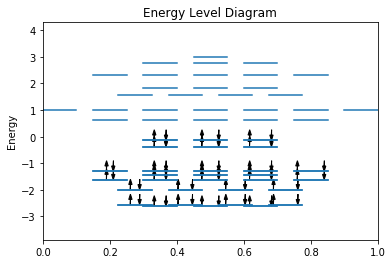

Electron energies: [-2.618  -2.618  -2.618  -2.618  -2.618  -2.618  -2.5616 -2.5616 -2.5616
 -2.5616 -2.5616 -2.5616 -2.5616 -2.5616 -2.     -2.     -2.     -2.     -2.
 -2.     -2.     -2.     -1.618  -1.618  -1.618  -1.618  -1.618  -1.618
 -1.618  -1.618  -1.618  -1.618  -1.4383 -1.4383 -1.4383 -1.4383 -1.4383
 -1.4383 -1.3028 -1.3028 -1.3028 -1.3028 -1.3028 -1.3028 -1.3028 -1.3028
 -1.3028 -1.3028 -0.382  -0.382  -0.382  -0.382  -0.382  -0.382  -0.1386
 -0.1386 -0.1386 -0.1386 -0.1386 -0.1386]
Occupation numbers: [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Total ground state energy: -93.1622b


In [26]:
# Very ugly function, try to improve

# Plots energy level diagram and determines electron energies
# args: ordered list of eigenvalues, number of electrons
# rets: list of energies for the Ne electrons
def energyLevel(evals,Ne,show=True):
    
    # parameters for drawing diagram
    mid = 0.5 # midpoint
    width = 0.1 # width of each line
    space = 0.05 # spacing between lines
    arrlen = 0.2 # arrow length
    hw = 0.01 # width of head of arrow
    hl = 0.2 # length of head of arrow

    # get unique list of energies
    # returns tuple of two arrays, ([energies],[multiplicity])
    uniq = np.unique(np.around(evals,4),return_counts=True)

    energies = np.zeros(Ne) # stores energies of each electron
    occu = np.zeros(N) # occupation number
    filled = 0 # keep track of how many electrons are left
    orb = 1 # keep track of current orbital
    
    for i in range(uniq[0].size): # go through each unique energy level
        E = uniq[0][i]
        m = uniq[1][i] # multiplicity
        start = mid - 0.5*(m-1)*(width+space) # where first line is drawn (left edge)
        
        turn = 1 # 1st or 2nd sweep through level
        j = 0 # keep track of degenerate energy levels
        
        while j < m:
            xL = start + j*(width+space) - 0.5*width # set bounds for drawing line
            xR = xL + width
            plt.axhline(E,xmin=xL,xmax=xR)
            if filled < Ne: 
                energies[filled] = E
                if turn == 1:
                    elec = 0.95*np.mean([xL,xR])
                    plt.arrow(elec,E,0,arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 1 # set occupation number to 1
                    if j == m-1:
                        turn = 2
                        j = 0
                        orb -= (m-1)
                        continue     
                elif turn == 2:
                    elec = 1.05*np.mean([xL,xR])
                    plt.arrow(elec,E+arrlen+hl,0,-arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 2
                orb += 1
            j += 1
    
    plt.ylabel("Energy")
    plt.xlim([0,1])
    plt.ylim([1.1*np.min(evals)-1,1.1*np.max(evals)+1])
    plt.title("Energy Level Diagram")
    if show:
        plt.show()
        
    return energies,occu

energies,occu = energyLevel(evals,Ne)
ETot = np.sum(energies)
print("Electron energies:",energies)
print("Occupation numbers:",occu)
print("Total ground state energy:",str(ETot)+"b")


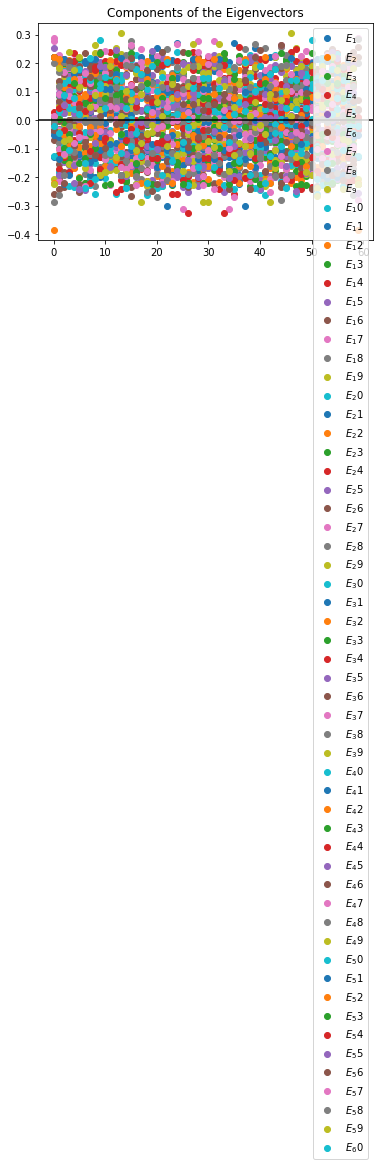

In [22]:
# Plot eigenvectors

for i in range(N):
    plt.plot(evecs[:,i],'o',label=r"$E_"+str(i+1)+"$")

plt.axhline(0,color='k')
plt.title("Components of the Eigenvectors")
plt.legend()
plt.show()

In [17]:
# Delocalization energy of butadiene
# energy difference from ground state and isolated double bonds (compare to ethylene)
# 

# determine delocalization energy, given total ground state energy and number of double bonds
def calcDeloc(E,numDB):
    Ne_ethy = 2
    evals_ethy = getEigs(ethy)[0]
    E_ethy = energyLevel(evals_ethy,Ne_ethy,show=False)[0]
    ETot_ethy = np.sum(E_ethy)
    deloc = numDB*ETot_ethy - ETot

    return deloc

numDB = 5 # number of double bonds (2 for butadiene, 3 for benzene, 5 for naphthalene)
deloc = calcDeloc(ETot,numDB)

print(str(deloc)+"b")

83.1622b


In [18]:
# Charge density estimation 
# for single electron in orbital I, |c_Ir|^2 is probability of electron being on atom r

def chargeDensity(evecs,energies,occu):
    q = np.zeros(N)
        
    for r in range(N):
        c = evecs[:,r] # get the rth component of eigenvector
        cSq = np.square(c)
        q[r] = np.dot(cSq,occu)
    
    return q

q = chargeDensity(evecs,energies,occu)

print(q)

[ 1.0000086   0.99987982  0.99996278  1.00002522  1.00002644  1.00003658
  0.99995998  0.99990212  0.99997106  0.99990978  1.00015508  1.00003728
  1.00016422  0.99998856  0.9999874   1.00004048  1.00005496  0.99983554
  1.00010376  0.99996794  0.99994568  1.00007508  1.00002666  0.99997492
  0.99991836  1.00006268  1.0000086   0.99988886  0.9999011   0.99995876
  1.00007648  1.00002132  1.00006088  1.0002494   1.0001496   1.00007176
  0.99997726  1.00018302  0.99993374  0.99988682  1.00003588  1.00007628
  1.00002474  1.00006732  1.00003768  1.0000418   0.99991004  1.00003412
  0.99992666  1.00013568  1.0001061   1.0003464   0.99999882  0.9998761
  1.00003262  1.0000756   1.00005676  0.99987908  1.00010112  1.00005952]


In [19]:
# Bond order calculation

def bondOrder(adj,evecs,energies,occu):
    adjUp = np.triu(adj) # remove redundant elements
    r,s = np.nonzero(adjUp) # get indices of nonzero elements
    p = np.zeros(r.size)
    
    for i in range(r.size):
        cr = evecs[:,r[i]]
        cs = evecs[:,s[i]]
                
        cPr = np.multiply(cr,cs)
        
        p[i] = np.dot(cPr,occu)
    
    return np.array([r,s,p])
    
p = bondOrder(adj,evecs,energies,occu)

print(p)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    1.00000000e+00   2.00000000e+00   2.00000000e+00   3.00000000e+00
    3.00000000e+00   4.00000000e+00   5.00000000e+00   5.00000000e+00
    6.00000000e+00   6.00000000e+00   7.00000000e+00   7.00000000e+00
    8.00000000e+00   8.00000000e+00   9.00000000e+00   1.00000000e+01
    1.00000000e+01   1.10000000e+01   1.20000000e+01   1.20000000e+01
    1.30000000e+01   1.30000000e+01   1.40000000e+01   1.50000000e+01
    1.50000000e+01   1.60000000e+01   1.70000000e+01   1.70000000e+01
    1.80000000e+01   1.80000000e+01   1.90000000e+01   2.00000000e+01
    2.00000000e+01   2.10000000e+01   2.20000000e+01   2.20000000e+01
    2.30000000e+01   2.30000000e+01   2.40000000e+01   2.50000000e+01
    2.50000000e+01   2.60000000e+01   2.70000000e+01   2.70000000e+01
    2.80000000e+01   2.80000000e+01   3.00000000e+01   3.00000000e+01
    3.00000000e+01   3.10000000e+01   3.20000000e+01   3.30000000e+01
    3.30000000e+01  